# What-if scenarios

In this stage of the analysis, we want to find how changes to the parameters of our model affect the simulated data.

Some areas of interest are:

- How would server utilisation (i.e. resource consumption) be affected by an increase in overall patient arrivals?
- How is the system affected by certain types of patients (e.g. short-stay, low-impact) arriving less frequently?
- What are the sensitivities of mean system times and server utilisation based on a change in $c$?

In [1]:
import itertools as it
import time

from ciw.dists import Exponential
from dask.diagnostics import ProgressBar
from scipy import stats

import ciw
import dask
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline
plt.style.use("seaborn-colorblind")


In [2]:
copd = pd.read_csv("../data/copd_clustered.csv", parse_dates=["admission_date", "discharge_date"])


In [3]:
def get_times(diff):

    times = diff.dt.total_seconds().div(24 * 60 * 60, fill_value=0)
    return times

    
def get_queue_params(data, prop=1, lambda_coeff=1, dist=stats.expon):
    """ Get the arrival and service parameters from `data` and the given `prop`. """

    inter_arrivals = (
        data.set_index("admission_date").sort_index().index.to_series().diff()
    )
    interarrival_times = get_times(inter_arrivals)
    lambda_ = lambda_coeff / np.mean(interarrival_times)

    mean_system_time = np.mean(data["true_los"])
    mu_estimate = mean_system_time * prop

    queue_params = {"arrival": lambda_, "service": 1 / mu_estimate}

    return queue_params


@dask.delayed
def simulate_queue(data, column, props, num_servers, seed, max_time, lambda_coeff=1):

    ciw.seed(seed)
    all_queue_params = {}
    for (label, subdata), service_prop in zip(
        data.groupby(column), props
    ):
        all_queue_params[label] = get_queue_params(subdata, service_prop, lambda_coeff)

    N = ciw.create_network(
        arrival_distributions={
            f"Class {label}": [Exponential(params["arrival"])]
            for label, params in all_queue_params.items()
        },
        service_distributions={
            f"Class {label}": [Exponential(params["service"])]
            for label, params in all_queue_params.items()
        },
        number_of_servers=[num_servers],
    )

    Q = ciw.Simulation(N)
    Q.simulate_until_max_time(max_time)

    return Q


def get_mean_server_utilisation(Q):

    return Q.transitive_nodes[0].server_utilisation


def get_simulation_results(Q, max_time):

    records = Q.get_all_records()
    results = pd.DataFrame(
        [r for r in records if max_time * 0.25 < r.arrival_date < max_time * 0.75]
    )

    results["system_time"] = results["exit_date"] - results["arrival_date"]
    return results[["system_time", "waiting_time", "queue_size_at_arrival", "customer_class"]]


In [4]:
with open("../data/wasserstein/best_params.txt", "r") as f:
    strings = f.read().split(" ")
    props, num_servers = list(map(float, strings[:-1])), int(strings[-1])

props, num_servers

([0.9, 1.0, 1.0, 0.5], 45)

In [5]:
seeds = 10
max_time = 365 * 3

tasks = (
    simulate_queue(copd, "cluster", props, num_servers, seed, max_time)
    for seed in range(seeds)
)

with ProgressBar():
    original_queues = dask.compute(*tasks, scheduler="processes", num_workers=6)

original_results = [get_simulation_results(Q, max_time) for Q in original_queues]

original_utilisation = np.mean([result["utilisation"].first() for result in original_results])
original_mean_time = np.mean([result["system_time"].mean() for result in original_results])


[########################################] | 100% Completed |  5.8s


## Change in overall patient arrivals

In [ ]:
lambda_coeff_range = np.linspace(0.5, 2, 50)

tasks = (
    simulate_queue(copd, "cluster", props, num_servers, seed, max_time, lambda_coeff)
    for lambda_coeff, seed in it.product(lambda_coeff_range, range(seeds))
)

with ProgressBar():
    lambda_queues = dask.compute(*tasks, scheduler="processes", num_workers=6)

lambda_results = [get_simulation_results(Q, max_time) for Q in lambda_queues]
lambda_utilisations = [get_mean_server_utilisation(Q) for Q in lambda_queues]


In [ ]:
relative_lambda_utilisations = np.array(lambda_utilisations).reshape(len(lambda_utilisations) // seeds, seeds) / original_utilisation


In [ ]:
fig, ax = plt.subplots(dpi=200)

xs = lambda_coeff_range
ax.plot(xs, relative_lambda_utilisations.mean(axis=1))
ax.fill_between(xs, relative_lambda_utilisations.min(axis=1), relative_lambda_utilisations.max(axis=1), alpha=0.25)

ax.set_xlabel("$\lambda$ scaling factor")
ax.set_ylabel("Mean relative utilisation")

In [ ]:
system_times = [result["system_time"].values for result in lambda_results]

min_system_times = [result["system_time"].quantile(.25) for result in lambda_results]
mean_system_times = [result["system_time"].mean() for result in lambda_results]
max_system_times = [result["system_time"].quantile(.75) for result in lambda_results]


In [ ]:
fig, ax = plt.subplots(dpi=200)

min_data = np.array(min_system_times).reshape(len(min_system_times) // seeds, seeds).min(axis=1) / original_mean_time
mean_data = np.array(mean_system_times).reshape(len(mean_system_times) // seeds, seeds).mean(axis=1) / original_mean_time
max_data = np.array(max_system_times).reshape(len(max_system_times) // seeds, seeds).max(axis=1) / original_mean_time

xs = lambda_coeff_range
ax.fill_between(xs, min_data, max_data, alpha=0.25)
ax.plot(xs, mean_data)

ax.set_xlabel("$\lambda$ scaling factor")
ax.set_ylabel("Mean relative system time (logscale)")

ax.set_yscale("log")


## Sensitivity analysis for $c$

In [ ]:
server_range = range(10, 91)

tasks = (
    simulate_queue(copd, "cluster", props, c, seed, max_time)
    for c, seed in it.product(server_range, range(seeds))
)

with ProgressBar():
    server_queues = dask.compute(*tasks, scheduler="processes", num_workers=6)

server_results = [get_simulation_results(Q, max_time) for Q in server_queues]
server_utilisations = [get_mean_server_utilisation(Q) for Q in server_queues]

In [ ]:
relative_server_utilisations = np.array(server_utilisations).reshape(len(server_utilisations) // seeds, seeds) / original_utilisation


In [ ]:
fig, ax = plt.subplots(dpi=200)

xs = np.array(server_range) / num_servers
ax.plot(xs, relative_server_utilisations.mean(axis=1))
ax.fill_between(
    xs, relative_server_utilisations.min(axis=1), relative_server_utilisations.max(axis=1), alpha=0.25
)

ax.set_xlabel("Relative no. servers")
ax.set_ylabel("Mean relative utilisation")

In [ ]:
system_times = [result["system_time"].values for result in server_results]

min_system_times = [result["system_time"].quantile(.05) for result in server_results]
mean_system_times = [result["system_time"].mean() for result in server_results]
max_system_times = [result["system_time"].quantile(.95) for result in server_results]


In [ ]:
fig, ax = plt.subplots(dpi=200)

min_data = np.array(min_system_times).reshape(len(min_system_times) // seeds, seeds).min(axis=1) / original_min_time
mean_data = np.array(mean_system_times).reshape(len(mean_system_times) // seeds, seeds).mean(axis=1) / original_mean_time
max_data = np.array(max_system_times).reshape(len(max_system_times) // seeds, seeds).max(axis=1) / original_max_time

xs = np.array(server_range) / num_servers
ax.fill_between(xs, min_data, max_data, alpha=0.25)
ax.plot(xs, mean_data)

ax.set_xlabel("Relative no. servers")
ax.set_ylabel("Mean relative system time (logscale)")

ax.set_yscale("log")


## Transferring patients between clusters

In [6]:
def update_arrival_params(all_queue_params, origin, destination, prop_to_move):

    origin_lambda = all_queue_params[origin]["arrival"]
    destination_lambda = all_queue_params[destination]["arrival"]

    destination_lambda += prop_to_move * origin_lambda
    origin_lambda *= 1 - prop_to_move

    all_queue_params[origin]["arrival"] = origin_lambda
    all_queue_params[destination]["arrival"] = destination_lambda

    return all_queue_params


@dask.delayed
def simulate_moving_clusters_queue(data, props, origin, destination, prop_to_move, seed, max_time):

    all_queue_params = {}
    for (label, cluster), service_prop in zip(
        data.groupby("cluster"), props
    ):
        all_queue_params[label] = get_queue_params(cluster, service_prop)

    all_queue_params = update_arrival_params(all_queue_params, origin, destination, prop_to_move)

    ciw.seed(seed)
    N = ciw.create_network(
        arrival_distributions={
            f"Class {label}": [Exponential(params["arrival"])]
            for label, params in all_queue_params.items()
        },
        service_distributions={
            f"Class {label}": [Exponential(params["service"])]
            for label, params in all_queue_params.items()
        },
        number_of_servers=[num_servers],
    )

    Q = ciw.Simulation(N)
    Q.simulate_until_max_time(max_time)

    results = get_simulation_results(Q, max_time)

    results["utilisation"] = Q.transitive_nodes[0].server_utilisation
    results["prop_to_move"] = prop_to_move
    results["origin"] = origin
    results["destination"] = destination
    results["seed"] = seed

    name = "_".join(map(str, [round(prop_to_move, 1), origin, destination, seed]))
    results.to_csv(f"../data/moving_clusters/{name}.csv", index=False)

    return results


In [21]:
prop_to_move_range = np.arange(0, 1, 0.05)
n_clusters = copd["cluster"].nunique()
label_combinations = [
    labels
    for labels in it.product(range(n_clusters), repeat=2)
    if labels[0] != labels[1]
]
seeds = 10

tasks = (
    simulate_moving_clusters_queue(copd, props, origin, destination, prop_to_move, seed, max_time)
    for (origin, destination), prop_to_move, seed in it.product(
        label_combinations, prop_to_move_range, range(seeds)
    )
)

with ProgressBar():
    moving_cluster_results = dask.compute(*tasks, scheduler="processes", num_workers=6)


[########################################] | 100% Completed | 13min 28.1s


In [22]:
all_moving_results = pd.concat(moving_cluster_results)

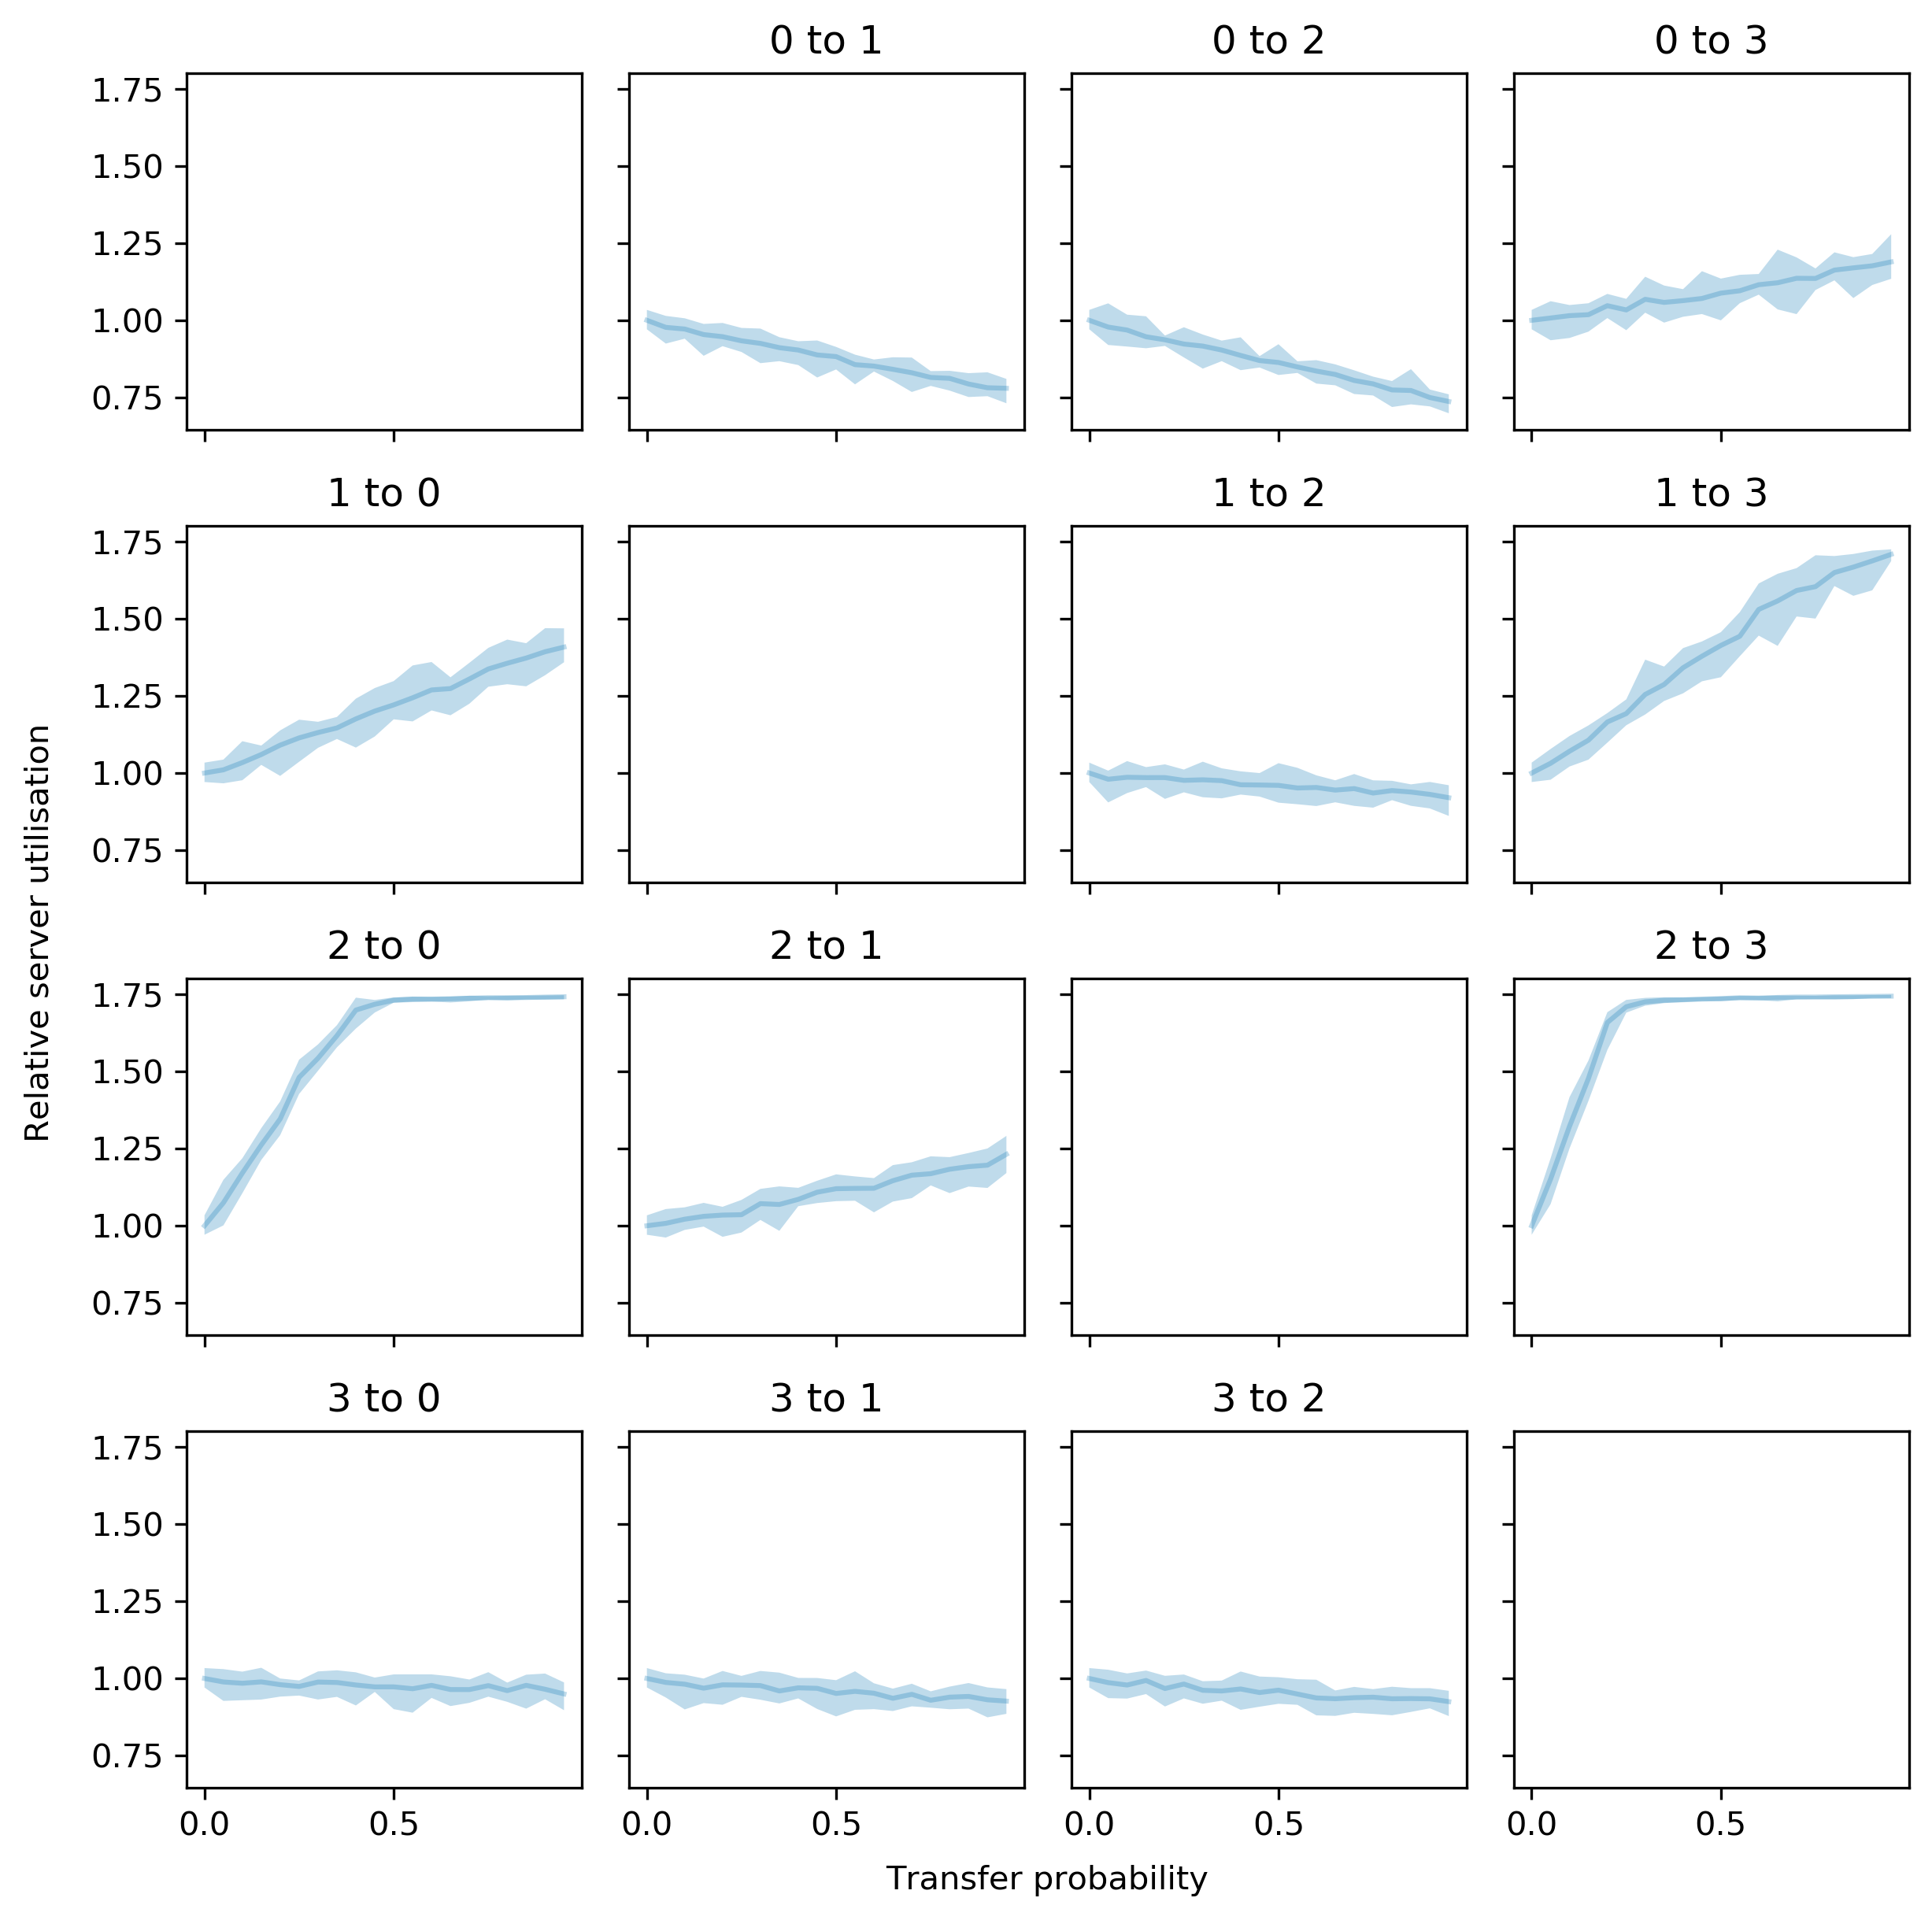

In [23]:
fig, axes = plt.subplots(nrows=n_clusters, ncols=n_clusters, sharex=True, sharey=True, figsize=(8, 8), dpi=300)

left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height

fig.text(
    0, 0.5*(bottom+top), "Relative server utilisation", ha="right", va="center", rotation="vertical"
)

fig.text(
    0.525*(left+right), -0.01, "Transfer probability", ha="center", va="bottom", rotation="horizontal"
)

for origin, destination in it.product(range(n_clusters), repeat=2):

    ax = axes[origin, destination]

    if origin != destination:
        data = all_moving_results[
            (all_moving_results["origin"] == origin)
            & (all_moving_results["destination"] == destination)
        ]

        fill = ax.fill_between(
            prop_to_move_range,
            data.groupby("prop_to_move")["utilisation"].quantile(.95) / original_utilisation,
            data.groupby("prop_to_move")["utilisation"].quantile(.05) / original_utilisation,
            alpha=0.25,
        )
        ax.plot(
            prop_to_move_range,
            data.groupby("prop_to_move")["utilisation"].mean() / original_utilisation,
            color=fill.get_facecolor()[0],
        )
        ax.set_title(f"{origin} to {destination}")

    plt.tight_layout()

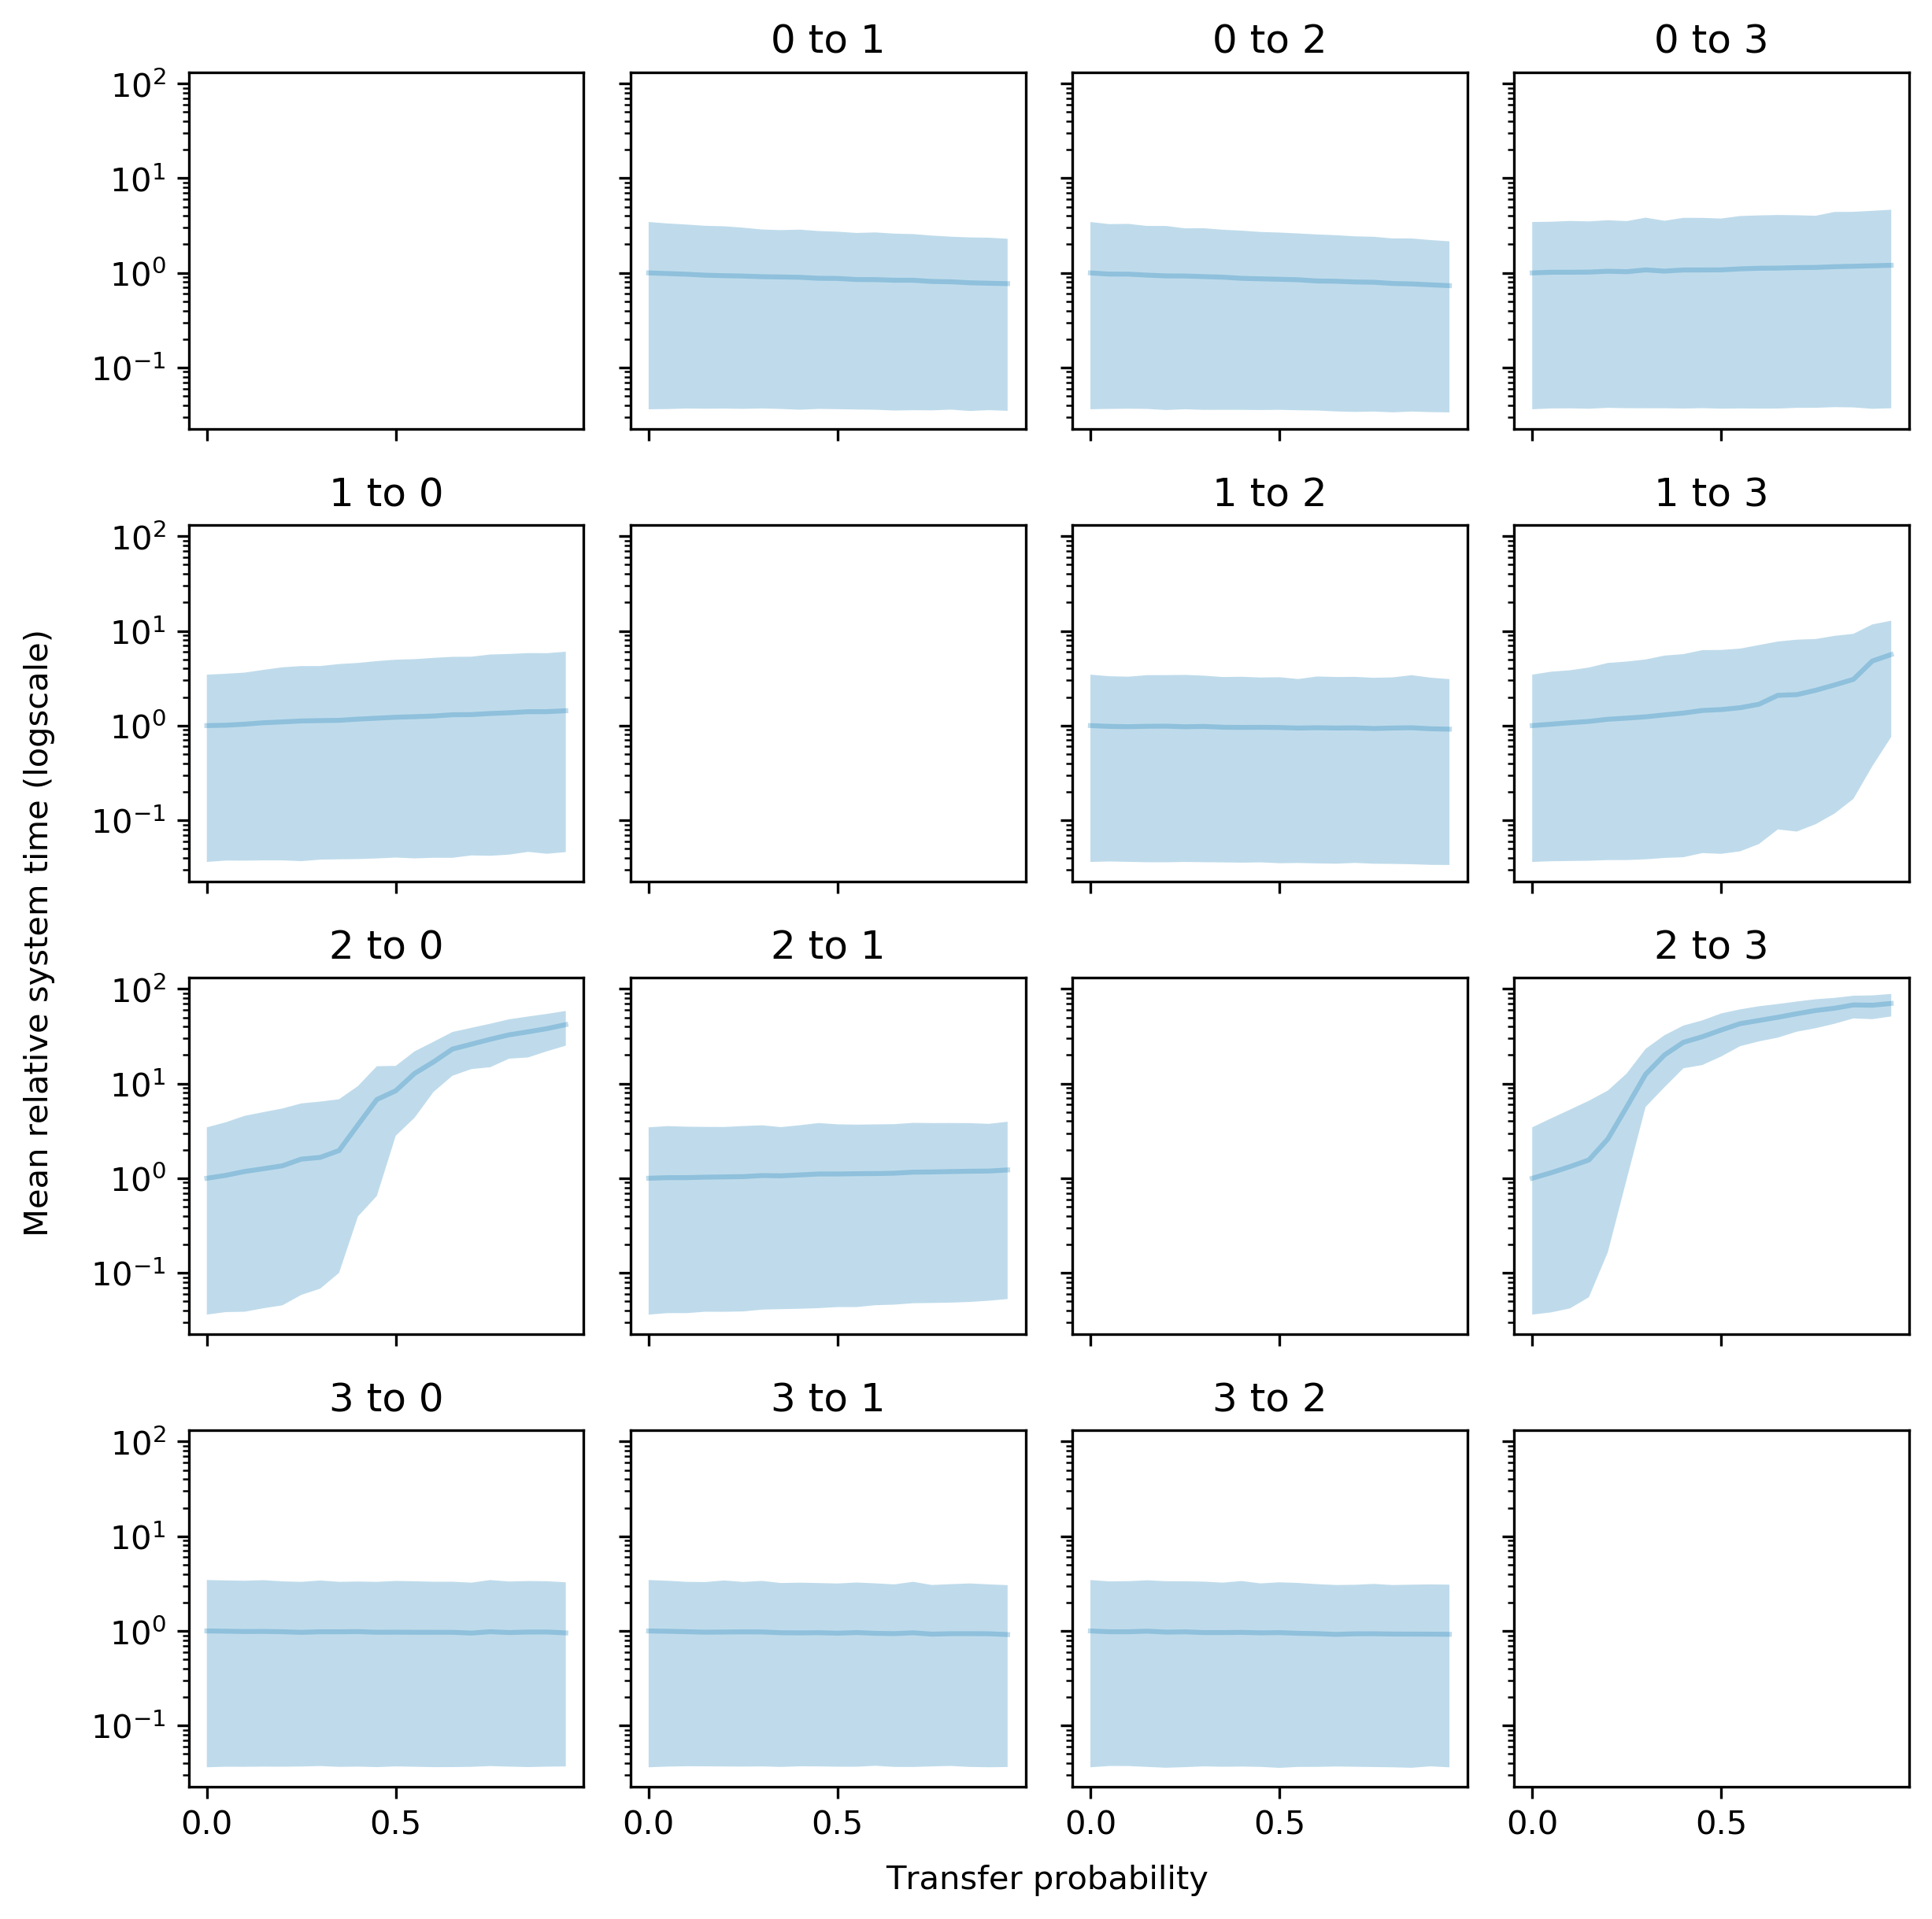

In [24]:
fig, axes = plt.subplots(nrows=n_clusters, ncols=n_clusters, sharex=True, sharey=True, figsize=(8, 8), dpi=300)

left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height

fig.text(
    0, 0.5*(bottom+top), "Mean relative system time (logscale)", ha="right", va="center", rotation="vertical"
)

fig.text(
    0.525*(left+right), -0.01, "Transfer probability", ha="center", va="bottom", rotation="horizontal"
)

for origin, destination in it.product(range(n_clusters), repeat=2):

    ax = axes[origin, destination]
    ax.set_yscale("log")

    if origin != destination:
        data = all_moving_results[
            (all_moving_results["origin"] == origin)
            & (all_moving_results["destination"] == destination)
        ]

        fill = ax.fill_between(
            prop_to_move_range,
            data.groupby("prop_to_move")["system_time"].quantile(.95) / original_mean_time,
            data.groupby("prop_to_move")["system_time"].quantile(.05) / original_mean_time,
            alpha=0.25,
        )
        ax.plot(
            prop_to_move_range,
            data.groupby("prop_to_move")["system_time"].mean() / original_mean_time,
            color=fill.get_facecolor()[0],
        )
        ax.set_title(f"{origin} to {destination}")

    plt.tight_layout()

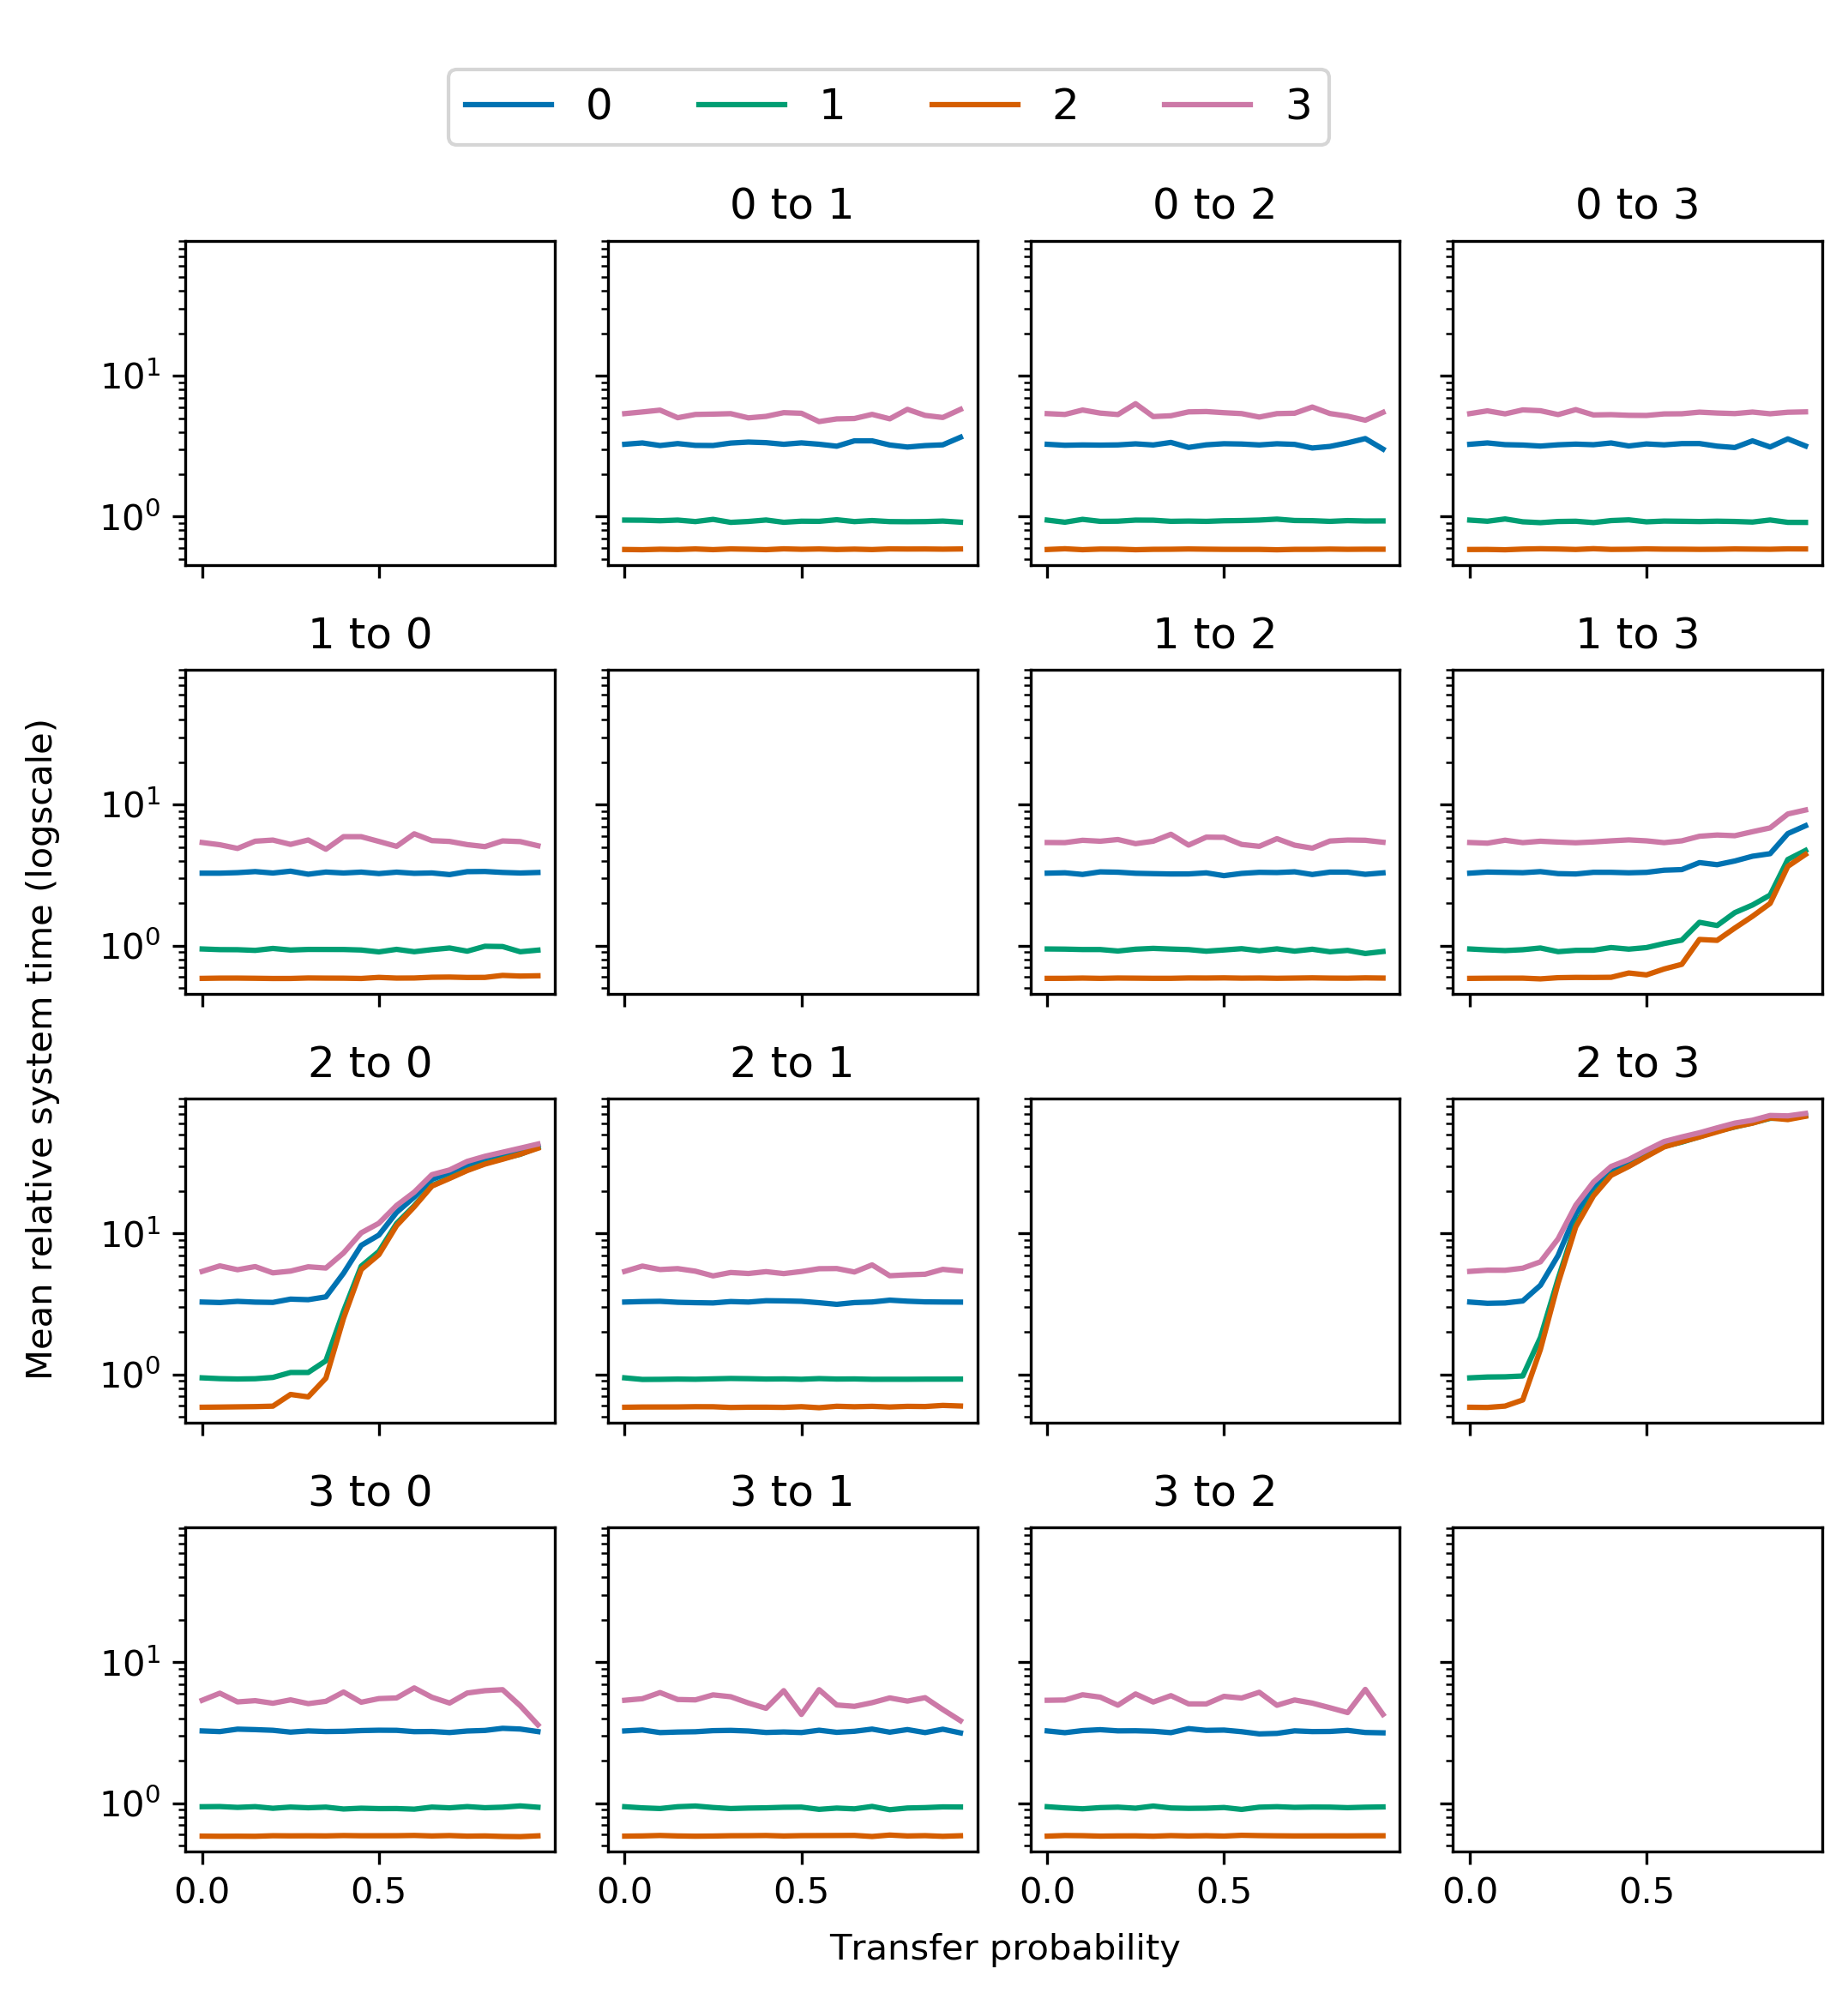

In [25]:
fig, axes = plt.subplots(nrows=n_clusters, ncols=n_clusters, sharex=True, sharey=True, figsize=(7, 7), dpi=300)

left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height

fig.text(
    0, 0.5*(bottom+top), "Mean relative system time (logscale)", ha="right", va="center", rotation="vertical"
)

fig.text(
    0.525*(left+right), -0.01, "Transfer probability", ha="center", va="bottom", rotation="horizontal"
)

for origin, destination in it.product(range(n_clusters), repeat=2):

    ax = axes[origin, destination]
    ax.set_yscale("log")

    if origin != destination:
        data = all_moving_results[
            (all_moving_results["origin"] == origin)
            & (all_moving_results["destination"] == destination)
        ]

        lines, labels = [], []
        for label, subdata in data.groupby("customer_class"):
            line = ax.plot(
                prop_to_move_range,
                subdata.groupby("prop_to_move")["system_time"].mean() / original_mean_time,
            )
            lines.append(line[0])
            labels.append(label)

        ax.set_title(f"{origin} to {destination}")

plt.figlegend(lines, labels, ncol=n_clusters, bbox_to_anchor=(0.75, 1.08), prop={'size': 12})
plt.tight_layout()
